In [ ]:
!pip install opencv-python

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import keras
from sklearn.metrics import f1_score
import cv2
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D, Input
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.applications.resnet50 import ResNet50
from sklearn.utils import shuffle

Using TensorFlow backend.


In [2]:
datapath = "dataset/"
img_width, img_height = 224,224
classes = ["manipuri", "bharatanatyam", "odissi", "kathakali", "kathak", "sattriya", "kuchipudi", "mohiniyattam"]
class_names_label = {classes:i for i, classes in enumerate(set(classes))}
num_classes = len(classes)
# resnet_weights_path = 'resnet_weights/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
# resnet_weights_path = ('https://github.com/fchollet/deep-learning-models/'
#                        'releases/download/v0.2/'
#                        'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height),interpolation=cv2.INTER_CUBIC)
    return resized

def norm_images(images):
    images = np.array(images,dtype = 'float32') / 255.  
    mean_img = np.mean(images,axis = 0)
    std_img = np.std(images,axis = 0)
    norm_img = (images - mean_img)/std_img
    return norm_img
#     return images

def load_dataset(folder_name):
    images = []
    labels = []
    label_file = pd.read_csv(os.path.join(datapath,folder_name+".csv"))
    for file in tqdm(os.listdir(os.path.join(datapath,folder_name))):
        if(folder_name == "train"):
            label = class_names_label[label_file[label_file["Image"] == file]["target"].values[0]]
            labels.append(label)
        else:
            labels.append(file)
        image = load_images(os.path.join(datapath,folder_name,file))
#         image = norm_images(image)
        images.append(image)
    images = norm_images(images)
    return (images,labels)

In [23]:
(x_train, y_train)=load_dataset("train")
x_train,y_train = shuffle(x_train,y_train,random_state = 42)
(x_test, img_name) = load_dataset("test")
y_train = np.array(y_train, dtype = 'int16')
y_train = to_categorical(y_train)

print(y_train.shape)

100%|██████████| 156/156 [00:00<00:00, 236.63it/s]


(364, 8)


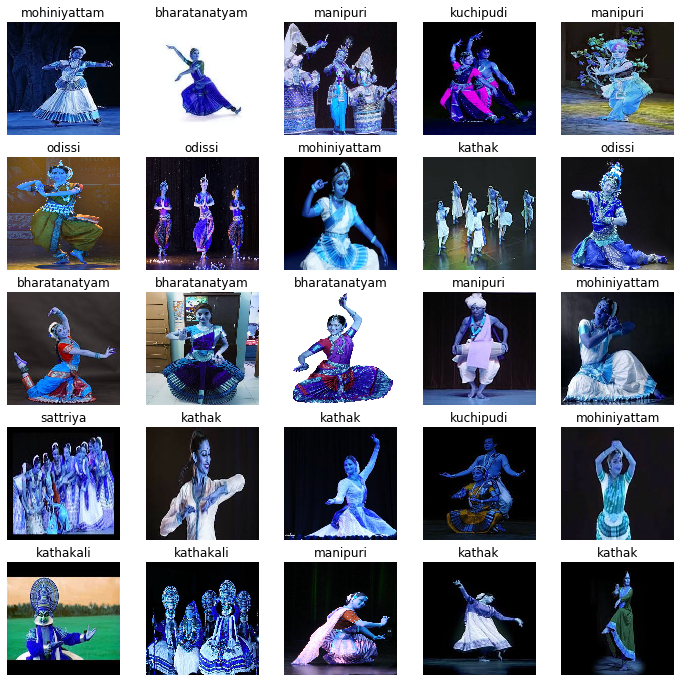

In [17]:
def show_batch(image_batch, label_batch):
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
#     print(y_maps)
    plt.figure(figsize=(12,12))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        pred = np.argmax(label_batch[n])
#         print(pred)
        plt.title(y_maps[pred])
        plt.axis('off')
show_batch(x_train,y_train)

In [6]:
def generate_sol(name, model):
    predictions = model.predict(x_test)
    predictions = np.argmax(predictions,axis = 1)
    y_maps = dict()
    y_maps = {v:k for k,v in class_names_label.items()}
    print(y_maps)
    print(predictions)
    pred_labels = [y_maps[k] for k in predictions]
    print(pred_labels)
    sub = pd.DataFrame({'Image':img_name,'target':pred_labels})
    model.save('resnet_weights/'+name+'weights.h5')
    sub.to_csv(name+'sol.csv', index = False)

In [24]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range = 40, width_shift_range=0.2,
        height_shift_range=0.2,
#         rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.3)
#val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow(x_train, y_train,subset="training",batch_size=32)
val_generator = datagen.flow(x_train, y_train,subset = "validation", batch_size=32)
#val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=30)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


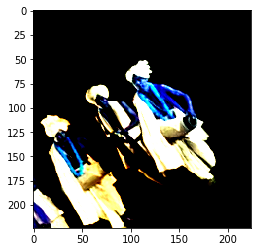

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


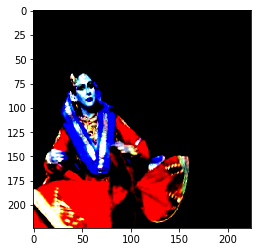

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


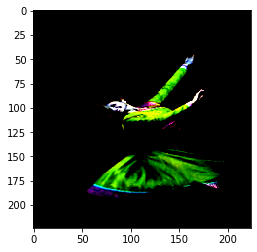

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


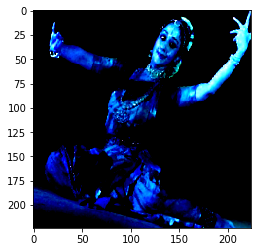

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


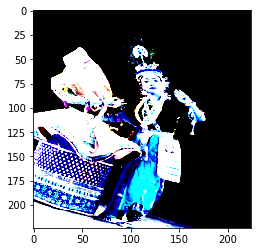

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


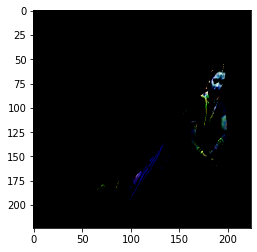

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


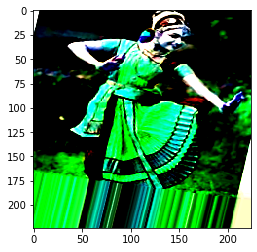

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


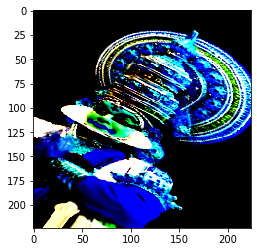

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


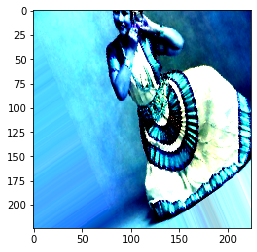

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


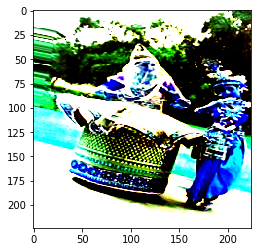

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


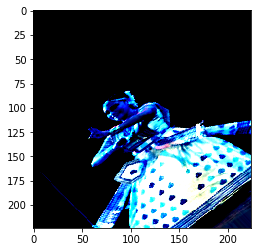

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


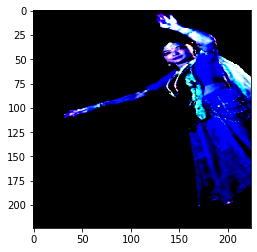

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


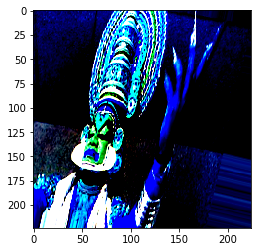

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


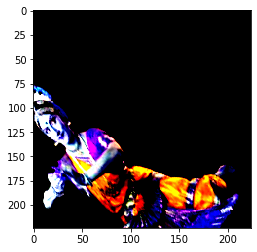

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


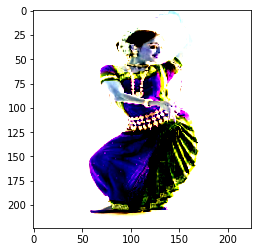

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


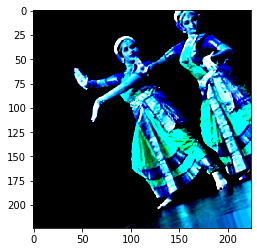

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


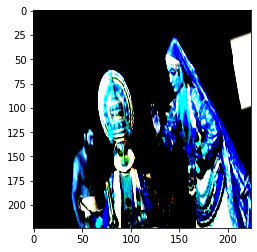

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


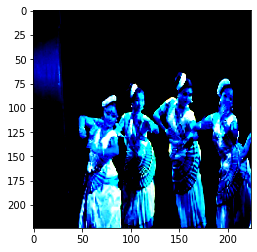

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


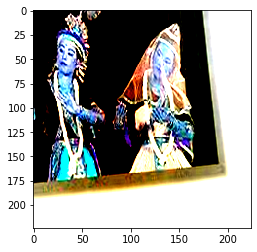

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


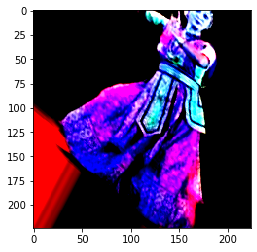

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


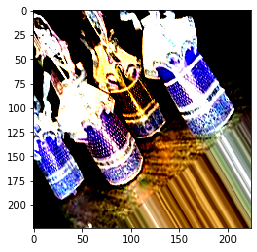

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


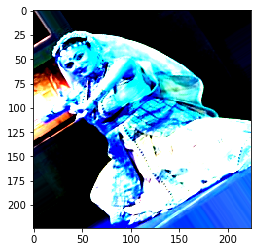

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


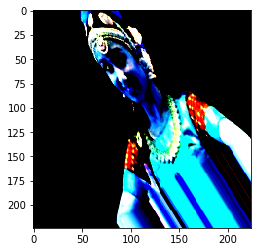

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


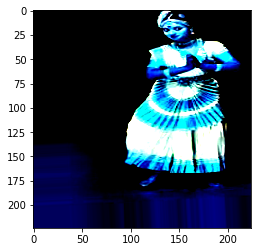

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


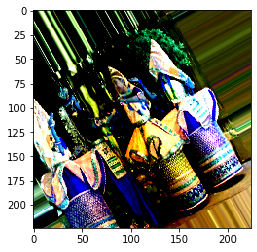

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


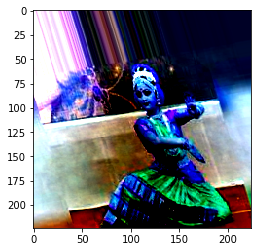

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


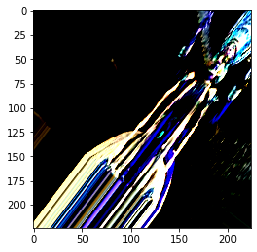

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


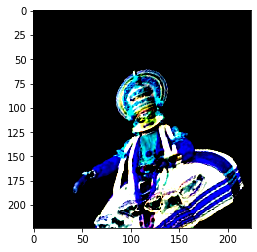

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


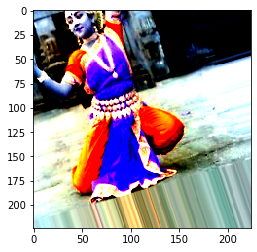

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


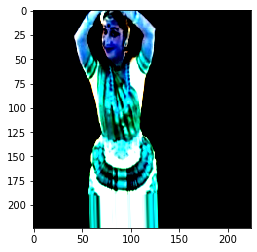

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


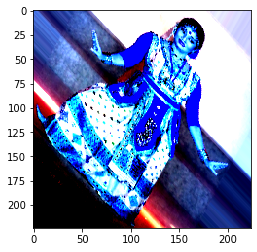

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


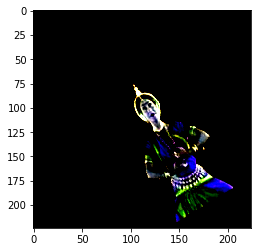

In [25]:
x_batch, y_batch = next(train_generator)
for i in range (0,32):
    image = x_batch[i]
#     print(image.shape)
    plt.imshow(image)
    plt.show()


# Experiment 1

In [26]:
cnnmodel = Sequential()
cnnmodel.add(Convolution2D(32, (3,3), activation='relu', padding='same',input_shape = (img_width, img_height,3)))
cnnmodel.add(Convolution2D(32, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))

cnnmodel.add(Convolution2D(64, (3,3), activation='relu', padding='same'))
cnnmodel.add(Convolution2D(64, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Convolution2D(128, (3,3), activation='relu', padding='same'))
cnnmodel.add(Convolution2D(128, (3,3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Flatten())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(256, activation='relu'))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Dense(y_train.shape[1], activation='softmax'))
cnnmodel.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
cnnmodel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 111, 111, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)       

In [ ]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

cnnmodel.fit(x_train, y_train, batch_size=100, epochs=20, validation_split=0.3, callbacks=[early_stops])
generate_sol("cnn", cnnmodel)

# Experiment 1 with data augumentation

In [ ]:
history = cnnmodel.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                          validation_data=val_generator, validation_steps=50, verbose=1)
generate_sol("cnndataaug",cnnmodel)

Epoch 1/10
100/100 [==============================] - 440s 4s/step - loss: 2.0053 - accuracy: 0.1813 - val_loss: 1.8742 - val_accuracy: 0.2478
Epoch 2/10
 33/100 [========>.....................] - ETA: 4:02 - loss: 1.7747 - accuracy: 0.2978

# Transfer Learning With ResNet50 

In [ ]:
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet',input_tensor=Input(shape=(img_width,img_height,3))))
model.add(Dense(1024, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.layers[0].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

model.fit(x_train, y_train, batch_size=100, epochs=15, validation_split=0.3, callbacks=[early_stops])
generate_sol("pretrained")

# ResNet50 without data augumentation

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', 
                                     input_shape=(img_width, img_height,3))

output = resnet.layers[-1].output
output = Flatten()(output)

resnet = Model(resnet.input, output)
resnet.trainable = False

for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

In [ ]:
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

In [ ]:
print("Trainable layers:", resnet.trainable_weights)

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Dense(1024, activation='relu', input_dim=(img_width, img_height,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
early_stops = EarlyStopping(patience=3, monitor='val_accuracy')

history1 = model.fit(x_train, y_train, batch_size=100, epochs=15, validation_split=0.3, callbacks=[early_stops])
generate_sol("withoutdataaug")

# ResNet with Data Augumentation

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu', input_dim=(img_width, img_height,3)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_train.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=10,
                          validation_data=val_generator, validation_steps=50, verbose=1)

In [ ]:
generate_sol("resnetdataaug")

In [ ]:
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# t = f.suptitle('Pre-trained CNN (Transfer Learning) Performance', fontsize=12)
# f.subplots_adjust(top=0.85, wspace=0.3)

# epoch_list = list(range(1,11))
# ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
# ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
# ax1.set_xticks(np.arange(0, 31, 5))
# ax1.set_ylabel('Accuracy Value')
# ax1.set_xlabel('Epoch')
# ax1.set_title('Accuracy')
# l1 = ax1.legend(loc="best")

# ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
# ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
# # ax2.set_xticks(np.arange(0, 31, 5))
# ax2.set_ylabel('Loss Value')
# ax2.set_xlabel('Epoch')
# ax2.set_title('Loss')
# l2 = ax2.legend(loc="best")